## Installs and imports

In [6]:
!pip install --upgrade pip #Standard pip upgrade
!pip install sentencepiece #Text tokeniser. More info: https://github.com/google/sentencepiece
!pip install transformers #HuggingFace API. More info: https://huggingface.co/docs/transformers/main/en/index

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 20.1 MB/s eta 0:00:00


In [7]:
from transformers import AutoTokenizer, AutoModel, AutoConfig #This will be used to create a class for the relevant architecture (Fit the correct model to the correct data)
from transformers import AutoModelForSequenceClassification #generic model class that goes along with the previous imports above
from torch.utils.data import DataLoader #PyTorch data loading utility
import numpy as np
from scipy.special import softmax #the softmax function (vector is transformed into another vector which sums to 1)
import pandas as pd

## Data

In [1]:
from google.colab import drive
drive.mount('/content/drive') #standard drive mounting


Mounted at /content/drive


In [8]:
df = pd.read_csv(r"/content/drive/MyDrive/TLS stuff/HINDI_dataset.csv") #fill in URL as appropriate

In [45]:
df = df.astype(str).applymap(lambda x: x[:514]) #panda's version of map
print(df.head())
dataset = (df['review'])
print (dataset.head(50))

                                              review sentiment
0  गुमनाम है वतन पर मिटने वाले लोग आतन्कवादियों स...         0
1  ज़ंजीर बदली जा रही थी मैं समझा था रिहाई हो गयी है         0
2  यूपी में बड़े स्तर पर दंगे करवा सकती है बीजेपी...         0
3  अंग्रेजी नहीं आती है इसलिए हिन्दी ट्विट ज्यादा...         0
4                    कश्मीर में हो रहा है जल जिहाद ।         0
0     गुमनाम है वतन पर मिटने वाले लोग आतन्कवादियों स...
1     ज़ंजीर बदली जा रही थी मैं समझा था रिहाई हो गयी है
2     यूपी में बड़े स्तर पर दंगे करवा सकती है बीजेपी...
3     अंग्रेजी नहीं आती है इसलिए हिन्दी ट्विट ज्यादा...
4                       कश्मीर में हो रहा है जल जिहाद ।
5     परमपिता परमेश्वर अगर हिंदुस्तान मेँ दंगा होता ...
6     संघर्ष में आदमी अकेला होता है सफलता में दुनिया...
7                                  मोहब्बत अंधी होती है
8     तीखी बात में राम जेठमलानी ने गड्गरी पर तो इल्ज...
9     एक मुलाकात जरूरी है रिहा होने के लिये ।एक उम्र...
10                     माओवादियों की संपत्ति होगी कुर्क
11    

## Model

For the github page, visit "XLM-T - A Multilingual Language Model Toolkit for Twitter", https://github.com/cardiffnlp/xlm-t

In [10]:
CUDA = True # set to true if using GPU (Runtime -> Change runtime Type -> GPU)
BATCH_SIZE = 1

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment" #chosen model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True) #use_fast simply loads the fast version of the Tokeniser
config = AutoConfig.from_pretrained(MODEL) # used for id to label name
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

if CUDA:
  model = model.to('cuda') #This sends the parameters to the GPU assigned in CUDA = True
_ = model.eval()

Downloading:   0%|          | 0.00/841 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

## Forward

In [11]:
def forward(text, cuda=True):
  encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
  if cuda:
    encoded_input.to('cuda')
    output = model(**encoded_input)
    scores = output[0].detach().cpu().numpy() #cuda parametrisation
  else:
    output = model(**encoded_input)
    scores = output[0].detach().numpy()
  
  scores = softmax(scores, axis=-1)
  return scores

In [12]:
print (np.size(dataset))

first_N_messages = dataset [:9076] #usually this is used to test a subset of a massive database. In this case, we can just pass the maximum length as the prediction doesn't take too long
print (np.size(first_N_messages))

9076
9076


In [13]:
dl = DataLoader(first_N_messages, batch_size=BATCH_SIZE)
all_preds = []

for idx, batch in enumerate(dl):
  print('Batch ',idx+1,' of ',len(dl)) #parsing through each element
  text = batch
  if (text != "nan"): #if non empty input (we hope our dataset controllers take care of this anyway, but just in case)
    scores = forward(text, cuda=CUDA)
    preds = np.argmax(scores, axis=-1)
    all_preds.extend(preds) #where the prediction actually happens

#print (all_preds)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Batch  1  of  4538
Batch  2  of  4538
Batch  3  of  4538
Batch  4  of  4538
Batch  5  of  4538
Batch  6  of  4538
Batch  7  of  4538
Batch  8  of  4538
Batch  9  of  4538
Batch  10  of  4538
Batch  11  of  4538
Batch  12  of  4538
Batch  13  of  4538
Batch  14  of  4538
Batch  15  of  4538
Batch  16  of  4538
Batch  17  of  4538
Batch  18  of  4538
Batch  19  of  4538
Batch  20  of  4538
Batch  21  of  4538
Batch  22  of  4538
Batch  23  of  4538
Batch  24  of  4538
Batch  25  of  4538
Batch  26  of  4538
Batch  27  of  4538
Batch  28  of  4538
Batch  29  of  4538
Batch  30  of  4538
Batch  31  of  4538
Batch  32  of  4538
Batch  33  of  4538
Batch  34  of  4538
Batch  35  of  4538
Batch  36  of  4538
Batch  37  of  4538
Batch  38  of  4538
Batch  39  of  4538
Batch  40  of  4538
Batch  41  of  4538
Batch  42  of  4538
Batch  43  of  4538
Batch  44  of  4538
Batch  45  of  4538
Batch  46  of  4538
Batch  47  of  4538
Batch  48  of  4538
Batch  49  of  4538
Batch  50  of  4538
Batch  51

In [14]:
print (np.size(all_preds)) #to confirm how much of our sample actually got processed

9076


In [15]:
print (all_preds) #optional print

[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 2, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 2, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 2, 0, 1, 0, 2, 0, 2, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 

In [16]:
print ("(0, 1, 2) predicted scores correspond to:") 
config.id2label[0], config.id2label[1], config.id2label[2] #labelling each of the scores accordingly

(0, 1, 2) predicted scores correspond to:


('Negative', 'Neutral', 'Positive')

In [20]:
for example in range(np.size(first_N_messages)):
  pred = all_preds[example]
  print(first_N_messages[example], '--->', config.id2label[pred]) #This shows, explicitly, each message processed, alongside each sentiment rating given.

Streaming output truncated to the last 5000 lines.
मान्यता प्राप्त दल से संबंधित न होने के कारण नामांकन पत्र अस्वीकृत कर दिया गया। ---> Negative
दुनियाभर में 10 करोड़ से ज्यादा डुप्लीकेट फेसबुक अकाउंट हो सकते हैं। ---> Neutral
यह त्वचा पर पड़ने वाले विपरीत प्रभावों से बचाने में मदद नहीं करता है। ---> Negative
इसके विपरीत चेन्नई की टीम बल्लेबाजी, गेंदबाजी और क्षेत्ररक्षण में शानदार नहीं रही है. ---> Negative
स्कूलों के विरुद्ध शिकायत मिलने पर कार्रवाई नहीं की जाएगी। ---> Negative
पीड़ित की तहरीर पर पुलिस ने तीन अज्ञात बदमाशों के विरुद्ध मुकदमा दर्ज कर लिया है किंतु घटना के 18 घंटे बाद भी उनके हाथ कोई सुराग नहीं लग सका था। ---> Neutral
चर्चित कहावत है कि न्याय में देरी करना न्याय न देने के समान है। ---> Negative
जिला पंचायत ने पत्र लिखकर इन गांवों के लिए पैसे न जारी करने कहा है। ---> Neutral
गिरने पर टूटने का खतरा ज्यादा है। ---> Negative
यूरोपीय दौरे पर गई भारतीय हॉकी टीम को अपने लगातार दूसरे मैच में हार का सामना करना पड़ा ---> Negative
जर्मन ओपन चैंपियन अरविंद भट्ट शुक्रवार को न्यूजीलै

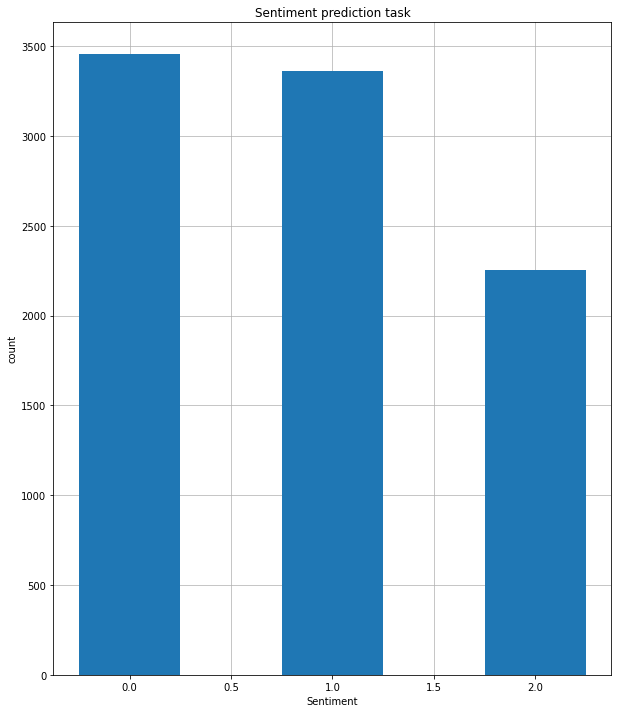

In [42]:
from matplotlib import pyplot as plt #now we plot our findings as a histogram
plt.figure(figsize=(10,12))
plt.grid(animated=True,alpha=0.9,zorder=-1)
plt.rcParams['axes.axisbelow'] = True
plt.hist(all_preds, bins=5, alpha=1,align="mid",range=[-0.25, 2.25])
plt.title('Sentiment prediction task')
plt.xlabel('Sentiment')
plt.ylabel('count')
plt.show()